In [ ]:
!pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv('survey lung cancer.csv')

In [ ]:
df['LUNG_CANCER'] = df['LUNG_CANCER'].map({'NO': 0, 'YES': 1})
df = pd.get_dummies(df, columns=['GENDER'])

In [ ]:
from sdv.metadata import SingleTableMetadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

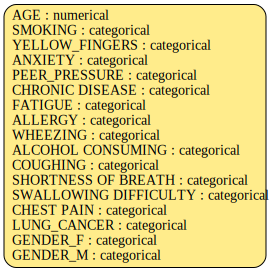

In [ ]:
metadata.visualize()

In [ ]:
from sdv.single_table import CopulaGANSynthesizer

synthesizer = CopulaGANSynthesizer(metadata)
synthesizer.fit(df)

synthetic_data = synthesizer.sample(num_rows=2000)

/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [ ]:
synthesizer = CopulaGANSynthesizer(
    metadata, # required
    enforce_min_max_values=True,
    enforce_rounding=False,
    epochs=500,
    verbose=True
)

/usr/local/lib/python3.10/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)


In [ ]:
synthetic_data.to_csv('synthetic_data.csv', index=False)

In [ ]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 17/17 [00:00<00:00, 1071.16it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 205.32it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [ ]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    df,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 17/17 [00:00<00:00, 1217.50it/s]|
Column Shapes Score: 89.67%

(2/2) Evaluating Column Pair Trends: |██████████| 136/136 [00:00<00:00, 231.42it/s]|
Column Pair Trends Score: 80.67%

Overall Score (Average): 85.17%



In [ ]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,AGE,KSComplement,0.396214
1,SMOKING,TVComplement,0.885393
2,YELLOW_FINGERS,TVComplement,0.871421
3,ANXIETY,TVComplement,0.849118
4,PEER_PRESSURE,TVComplement,0.929618
5,CHRONIC DISEASE,TVComplement,0.917646
6,FATIGUE,TVComplement,0.945639
7,ALLERGY,TVComplement,0.951866
8,WHEEZING,TVComplement,0.958366
9,ALCOHOL CONSUMING,TVComplement,0.963634


In [ ]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data,
    column_name='LUNG_CANCER',
    metadata=metadata
)

fig.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features (excluding the 'SUBJECT_ID' and the target 'TYPE')
X = synthetic_data.drop(columns=['LUNG_CANCER'])
y = synthetic_data['LUNG_CANCER']

# Standardize the features for better performance in logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Let's inspect the shapes to make sure everything looks correct
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 16), (400, 16), (1600,), (400,))

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model using the training data
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred = log_reg.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.865


In [ ]:
# Get the feature coefficients (weights)
coefficients = log_reg.coef_[0]

# Function to calculate the sigmoid of a value
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Function to calculate the summary for each data point
def generate_summary(X_test, coefficients, feature_names, model):
    results = []

    # Compute the linear model (dot product of X and coefficients) and the probabilities
    linear_model = np.dot(X_test, coefficients) + model.intercept_[0]
    probabilities = sigmoid(linear_model)

    # Loop through each data point in the test set
    for idx, (sample, prob) in enumerate(zip(X_test, probabilities)):
        # Calculate contributions for all features for this sample
        contributions = sample * coefficients
        absolute_contributions = np.abs(contributions)

        # Find the most important feature (the one with the highest absolute contribution)
        most_important_feature_idx = np.argmax(absolute_contributions)
        most_important_feature = feature_names[most_important_feature_idx]
        contribution_value = contributions[most_important_feature_idx]

        # Add the summary for this data point
        results.append({
            'Data Point': idx + 1,
            'Most Important Feature': most_important_feature,
            'Contribution Value': contribution_value,
            'Predicted Probability (P(y=1))': prob
        })

    # Convert results to a DataFrame
    summary_df = pd.DataFrame(results)

    return summary_df

# Generate the summary for all test samples
summary_table = generate_summary(X_test, coefficients, X.columns, log_reg)

# Display the first few rows of the summary
summary_table.head(20)  # Displaying the top 20 rows for brevity

,Data Point,Most Important Feature,Contribution Value,Predicted Probability (P(y=1))
0,1,YELLOW_FINGERS,-0.161438,0.846982
1,2,YELLOW_FINGERS,0.127360,0.894280
2,3,YELLOW_FINGERS,-0.161438,0.872449
3,4,YELLOW_FINGERS,-0.161438,0.857338
4,5,YELLOW_FINGERS,0.127360,0.892966
5,6,YELLOW_FINGERS,0.127360,0.915471
6,7,YELLOW_FINGERS,0.127360,0.923991
7,8,YELLOW_FINGERS,0.127360,0.878192
8,9,YELLOW_FINGERS,0.127360,0.898267
9,10,YELLOW_FINGERS,-0.161438,0.897880


In [ ]:
summary_table['Most Important Feature'].value_counts()

,count
Most Important Feature,
YELLOW_FINGERS,382
AGE,18


In [ ]:
# Assuming 'Most Important Feature' is the column in your summary table
important_features_list = summary_table['Most Important Feature'].value_counts().index.tolist()

# Print the important features list
print(important_features_list)

['YELLOW_FINGERS', 'AGE']


for running only customize features

SAINT

Epoch 10/50, Loss: 0.4124, Train Acc: 0.8775, Test Acc: 0.8650
Epoch 20/50, Loss: 0.3769, Train Acc: 0.8775, Test Acc: 0.8650
Epoch 30/50, Loss: 0.3746, Train Acc: 0.8775, Test Acc: 0.8650
Epoch 40/50, Loss: 0.3726, Train Acc: 0.8775, Test Acc: 0.8650
Epoch 50/50, Loss: 0.3719, Train Acc: 0.8775, Test Acc: 0.8650
Final Test Accuracy: 0.8650


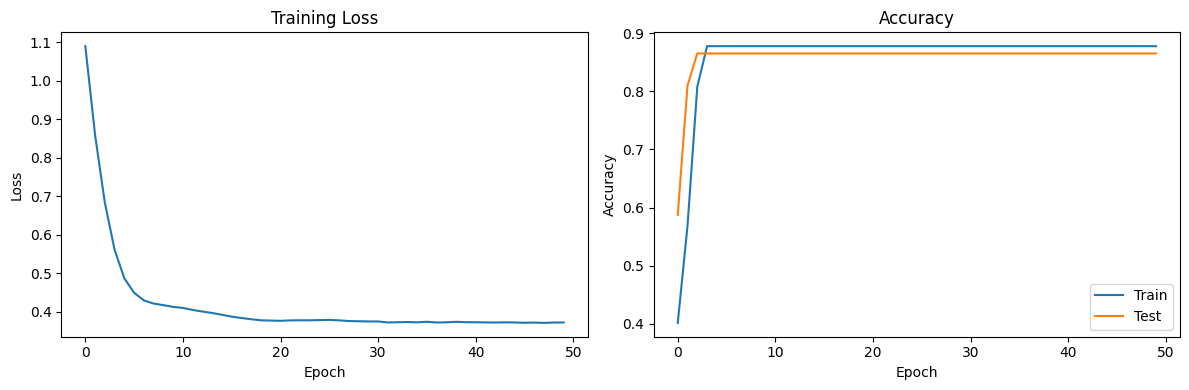

In [ ]:
# Load the synthetic data from CSV and prepare it for the SAINT model
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the data
file_path = 'synthetic_data.csv'
data = pd.read_csv(file_path)

# Split features and target

X = data[important_features_list].values
y = data['LUNG_CANCER'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define the SAINT model
class SimpleSAINT(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_heads=4, num_classes=3):
        super(SimpleSAINT, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim,
            num_heads=num_heads,
            batch_first=True
        )
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        attention_out, _ = self.attention(x, x, x)
        x = self.norm1(x + attention_out)
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        x = torch.mean(x, dim=1)
        x = self.classifier(x)
        return x

# Initialize model, loss function, and optimizer
input_dim = X_train.shape[1]
model = SimpleSAINT(input_dim=input_dim, hidden_dim=64, num_heads=4, num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Calculate training accuracy
    _, predicted_train = torch.max(outputs.data, 1)
    train_acc = accuracy_score(y_train.numpy(), predicted_train.numpy())

    # Calculate test accuracy
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        _, predicted_test = torch.max(test_outputs.data, 1)
        test_acc = accuracy_score(y_test.numpy(), predicted_test.numpy())

    # Store metrics
    train_losses.append(loss.item())
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# Final evaluation
model.eval()
with torch.no_grad():
    final_outputs = model(X_test)
    _, predicted = torch.max(final_outputs.data, 1)
    final_accuracy = accuracy_score(y_test.numpy(), predicted.numpy())

print(f"Final Test Accuracy: {final_accuracy:.4f}")

# Plot training curves
plt.figure(figsize=(12, 4))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()